## 8-1.프로젝트 : CIFAR-10 이미지 생성하기

GAN을 학습하는 과정은 보기보다 까다롭습니다. 모델 구조, learning_rate, 파라미터 초기화, 생성자와 판별자의 경쟁 관계, 데이터의 특성 등 고려해야 할 것이 참 많습니다.

이번에는 앞에서 배운 FASHION-MNIST 데이터 생성용 DCGAN 모델구조를 이용해서 CIFAR-10 데이터를 생성하는 모델을 직접 만들어 봅시다.
모델 구현 및 학습의 전과정의 흐름은 거의 비슷하겠지만, 아래와 같이 몇 가지 달라지는 점이 있습니다.

- 이미지 데이터의 shape가 (28, 28, 1)에서 (32, 32, 3)으로 변경됩니다. 생성자, 판별자 모델의 입출력 shape 및 모델 구조에 영향이 있습니다.
- 이미지가 단색의 grayscale에서 RGB 3채널의 컬러이미지로 변경됩니다. 시각화 과정에서 고려할 점이 있습니다.
- 입력데이터 전체 차원이 3~4배 증가하면서, 학습이 진행되는 양상이 다소 달라집니다.

우선 주요 라이브러리 버전을 확인하고 진행합시다.

In [98]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)
print("imageio", imageio.__version__)

NUM_TRAIN_DATA = 50000
IMAGE_SIZE = 32

tensorflow 2.6.0
imageio 2.9.0


### STEP 1. 작업환경 구성하기

다음과 같이 작업환경을 구성합시다.
```
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history
```

### STEP 2. 데이터셋 구성하기

CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [169]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.
학습 시간이 너무 오래 걸린다면 한 종류의 데이터만 추출해 진행해도 좋습니다. 아래 코드는 참고만 하세요.

In [170]:
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x

In [171]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [172]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [173]:
train_x.shape

(50000, 32, 32, 3)

(32, 32, 3)
255 0


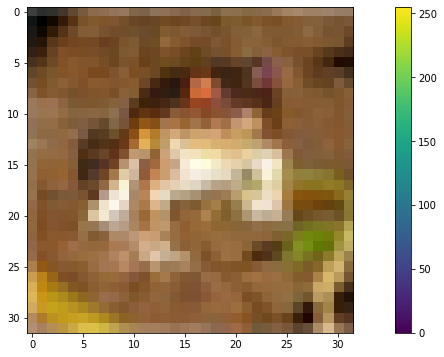

In [174]:
img = train_x[0]
img = (img * 127.5 + 127.5).astype("int16")
print(img.shape)
print(img.max(), img.min())
plt.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3), cmap='viridis')
plt.colorbar()
plt.show()

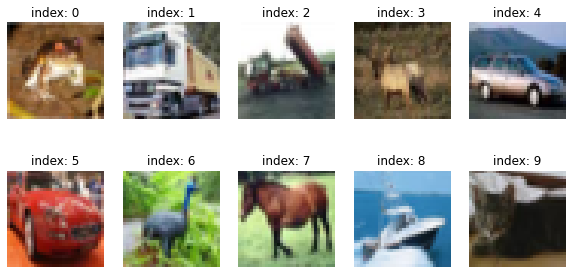

In [175]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)

    img = (train_x[i] * 127.5 + 127.5).astype("int16")
    plt.imshow(img, cmap='viridis')
    #plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

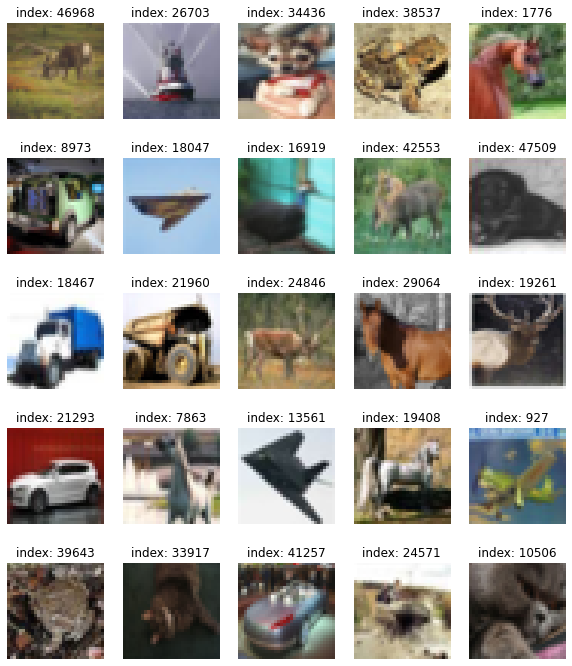

In [176]:
plt.figure(figsize=(10, 12))

random_indices = np.random.choice(train_x.shape[0], 25, replace = False)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    img = (train_x[random_indices[i]] * 127.5 + 127.5).astype("int16")
    plt.imshow(img)
    plt.title(f'index: {random_indices[i]}')
    plt.axis('off')

plt.show()

In [177]:
BUFFER_SIZE = train_x.shape[0]
BATCH_SIZE = 256

In [178]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3 : 생성자 모델 구현하기
- 이미지 사이즈 : 8x8x256 -> 16x16x64 -> 32x32x3

In [179]:
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(units = 8 * 8 * 256, input_shape = (100, ), use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(128, kernel_size = 5, strides = 1, padding = "same", use_bias = False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    # 커널 크기는 5, stride는 2, 패딩은 사용, 편향은 사용하지 않음
    model.add(layers.Conv2DTranspose(64, kernel_size = 5, strides = 2, padding = "same", use_bias = False))
    # 배치 정규화 사용
    model.add(layers.BatchNormalization())
    # LeakyReLU 활성화 함수 사용
    model.add(layers.LeakyReLU())

#     # Fifth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose(32, kernel_size = 5, strides = 2, padding = "same", use_bias = False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

# from tensorflow.keras import layers

# def make_generator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(units = 4 * 4 * 256, input_shape = (100, ), use_bias = False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha = 0.2))

#     # Second: Reshape layer
#     model.add(layers.Reshape((4, 4, 256)))

#     # Third: Conv2DTranspose layer
#     # 커널 크기는 5, stride는 1, 패딩은 사용, 편향은 사용하지 않음
#     model.add(layers.Conv2DTranspose(128, kernel_size = 4, strides = 1, padding = "same", use_bias = False))
#     # 배치 정규화 사용
#     model.add(layers.BatchNormalization())
#     # LeakyReLU 활성화 함수 사용
#     model.add(layers.LeakyReLU(alpha = 0.2))

#     model.add(layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = "same", use_bias = False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha = 0.2))

#     model.add(layers.Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = "same", use_bias = False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU(alpha = 0.2))
    
#     model.add(layers.Conv2DTranspose(3, kernel_size = 4, strides = 2, padding = "same", use_bias = False,
#                                     activation = 'tanh'))

#     return model



In [180]:
generator = make_generator_model()

generator.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_36 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_37 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_63 (LeakyReLU)   (None, 8, 8, 128)       

In [181]:
noise = tf.random.normal([1, 100])

In [182]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(118.89981, shape=(), dtype=float32) tf.Tensor(136.29771, shape=(), dtype=float32) tf.Tensor(127.68313, shape=(), dtype=float32)


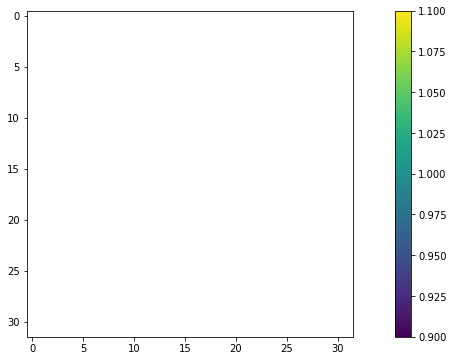

In [183]:
img = (generated_image[0] * 127.5 + 127.5)

print(tf.reduce_min(img), tf.reduce_max(img), tf.reduce_mean(img))
plt.imshow(img)
plt.colorbar()
plt.show()

In [184]:
# BUGBUG : 값이 너무 작아서 확인이 필요할 듯
generated_image[0]

<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
array([[[ 2.54377141e-03,  2.20229337e-03,  2.76516611e-03],
        [ 6.12963364e-03,  9.58998688e-04,  9.95952752e-04],
        [ 5.39884763e-03,  3.74913076e-03,  2.08679191e-03],
        ...,
        [-5.17898286e-03,  8.48695345e-04,  1.25860814e-02],
        [ 6.50016475e-04,  5.64122340e-03, -3.61873256e-03],
        [ 4.39413823e-03,  1.68604264e-03,  2.47321953e-03]],

       [[-3.40658543e-03,  1.47373520e-03, -4.69380198e-03],
        [ 4.40377090e-03, -4.93317237e-03, -7.89092854e-04],
        [-9.12308041e-03,  2.68135522e-03, -2.01674132e-03],
        ...,
        [ 4.05372726e-03,  2.69451085e-03, -9.44452174e-03],
        [ 3.71416681e-03, -1.09858206e-03,  4.96487226e-03],
        [ 1.23597672e-02, -1.06366435e-02, -1.81488052e-03]],

       [[-1.94514764e-03, -5.39620034e-03, -1.39959832e-03],
        [-4.93336609e-03, -1.25249485e-02, -3.83082614e-03],
        [-8.15876760e-03, -4.84767137e-03,  1.77787279e-03],
  

In [185]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-1.2011175 , -0.57592595, -0.9140836 , -0.21777852,  0.5523717 ,
         1.0956366 , -0.52282155,  0.9959743 ,  1.0027636 ,  0.62710696,
         0.37368605, -0.04975329, -1.2314012 , -0.69503766,  1.0696663 ,
        -0.27851367, -2.7421103 , -0.59060055,  0.85321647, -0.8334817 ,
         0.19886409,  2.0510197 , -1.3371047 ,  0.8399775 ,  0.13341591,
         1.0161685 , -1.0261214 , -0.8011221 ,  0.39841393,  0.06186298,
        -1.1999435 ,  1.1281576 , -0.9444317 , -0.4436561 , -0.874243  ,
        -2.8783293 , -0.3403472 ,  0.840664  , -0.11451489,  0.23696308,
        -1.5647808 ,  0.70820546,  0.3405702 , -2.6362891 , -2.3742073 ,
         1.8605704 ,  2.0354898 , -0.83576334,  1.3157873 ,  0.7903535 ,
         0.0390087 , -0.17291252,  0.39994904,  1.4853443 , -0.07390588,
        -0.02516093, -2.1314979 , -0.66596526, -1.3708166 , -1.8300642 ,
         0.2549475 , -0.89647526, -0.32444578,  1.5895714 , -0.89010715,
 

### STEP 4 : 판별자 모델 구현하기
- 32x32x3 -> 16x16x64 -> 8x8x128 -> 1

In [186]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, kernel_size = 5, strides = 2, padding = "same", input_shape = (32, 32, 3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, kernel_size = 5, strides = 2, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.01))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

# def make_discriminator_model():

#     # Start
#     model = tf.keras.Sequential()

#     # First: Conv2D Layer
#     # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
#     model.add(layers.Conv2D(64, kernel_size = 3,  padding = "same", input_shape = (32, 32, 3)))
#     model.add(layers.LeakyReLU())

#     # Second: Conv2D Layer
#     # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
#     model.add(layers.Conv2D(128, kernel_size = 4, strides = 2, padding = "same"))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.LeakyReLU(alpha = 0.2))

#     model.add(layers.Conv2D(128, kernel_size = 4, strides = 2, padding = "same"))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.LeakyReLU(alpha = 0.2))

#     model.add(layers.Conv2D(128, kernel_size = 4, strides = 1, padding = "same"))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.LeakyReLU(alpha = 0.2))

#     # Third: Flatten Layer
#     model.add(layers.Flatten())
#     #model.add(layers.Dropout(0.3))

#     # Fourth: Dense Layer
#     model.add(layers.Dense(1, activation = "sigmoid"))

#     return model

In [187]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)            

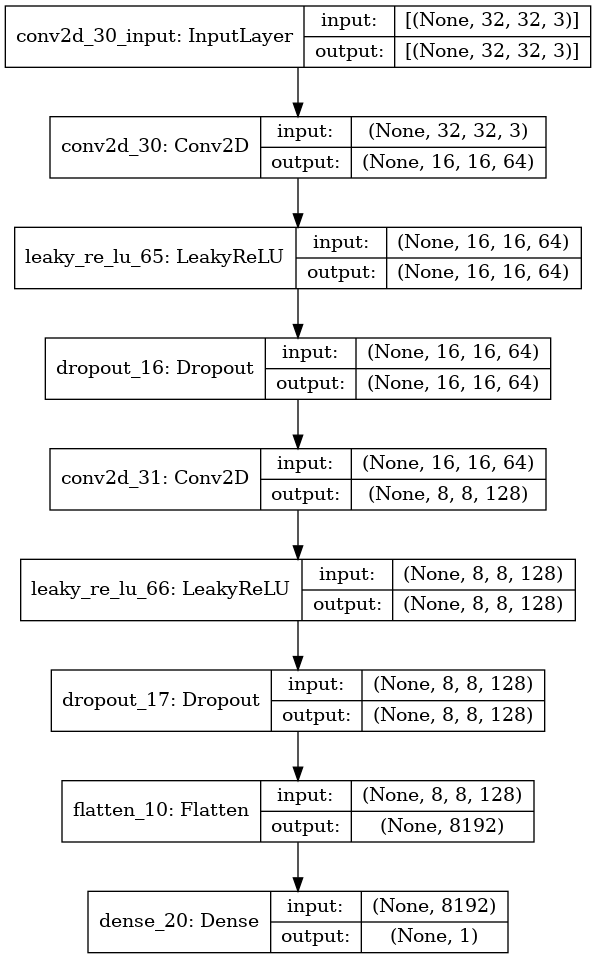

In [188]:
tf.keras.utils.plot_model(discriminator, show_shapes = True)

In [189]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00264399]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

In [190]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [191]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [192]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

In [193]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [194]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [195]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기


In [214]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training = True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [197]:
# 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화
# 이미지를 0 ~ 256 스케일로 바꿔서 저장한다.
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False).numpy()

    fig = plt.figure(figsize=(4, 4))

    predictions = (predictions * 127.5) + 127.5   # reverse of normalization
    predictions = predictions.astype(int)

    #print(tf.reduce_min(predictions[0]), tf.reduce_max(predictions[0]), tf.reduce_mean(predictions[0]))
    #print(predictions[0])
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i], cmap = 'viridis')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [198]:
# 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 
# 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### STEP 7. 학습과정 진행하기

In [199]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [200]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [201]:
save_every = 5
#EPOCHS = 100
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

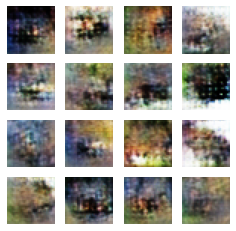

Time for training : 758 sec


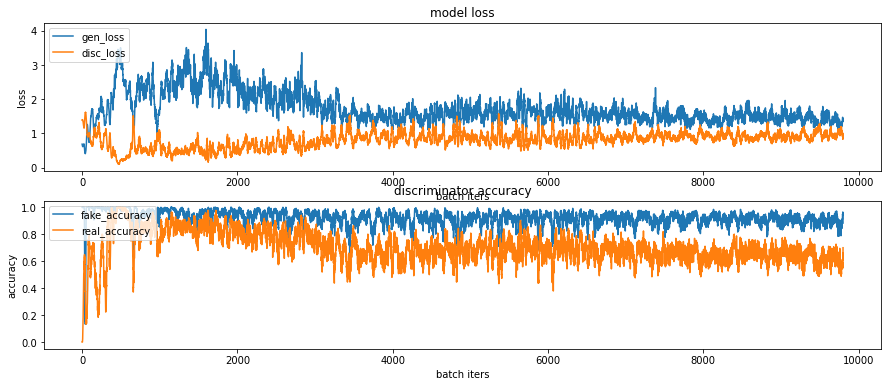

In [132]:
train(train_dataset, epochs = EPOCHS, save_every = save_every)

checkpoint 모듈을 활용하여 저장한 모델을 로드하는 예시

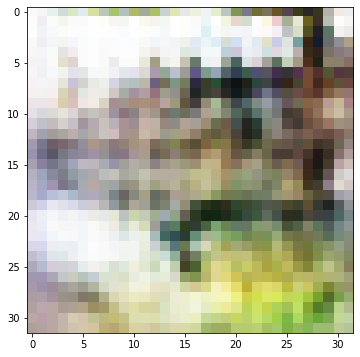

In [133]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### STEP 8. GAN 훈련 과정 개선하기
- loss function을 최소제곱 손실 함수로 대체함
- EPOCHS을 늘여 볼 예정

In [138]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)            

In [139]:
generator = make_generator_model()

generator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_17 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 8, 8, 128)       

손실 함수를 least square로 대체

In [ ]:

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.square(real_output - 1))
    fake_loss = tf.reduce_mean(tf.square(fake_output))
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return tf.reduce_mean(tf.square(fake_output - 1))

EPOCHS = 50만큼 학습

In [142]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

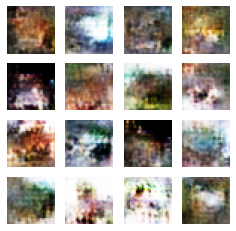

Time for training : 762 sec


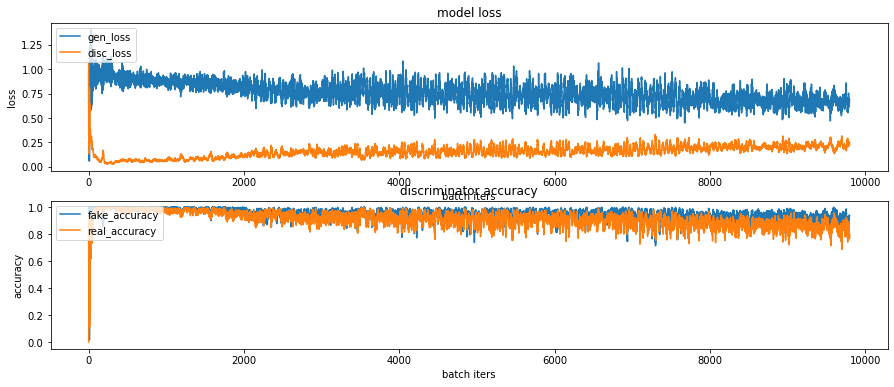

In [143]:
train(train_dataset, epochs = EPOCHS, save_every = save_every)

EPOCHS = 100 번 추가 학습

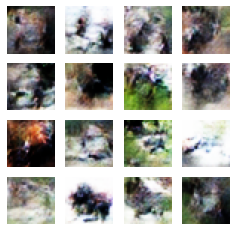

Time for training : 1558 sec


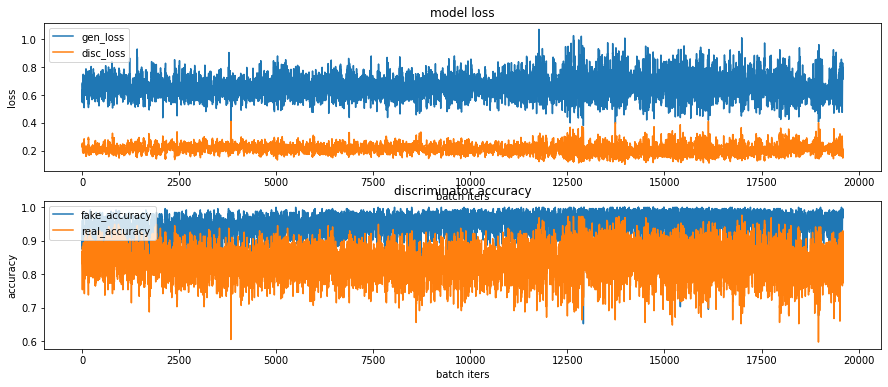

In [145]:
EPOCHS = 100
train(train_dataset, epochs = EPOCHS, save_every = save_every)

- 이미지가 부드러워지고 형상이 보이는 것 같지만 구체적인 모습은 모르겠음.
- real_accuracy와 fake_accuracy가 겹치는 부분이 보이지만, fake accuracy가 1 가까이 있음


### STEP 8. GAN 훈련 과정 개선하기 - 2
- fake acurracy가 높게 나와서 generator의 성능을 좀더 높이는 시도를 해봄
- generator의 층은 한층 더 쌓고, fiter size를 4로 줄임(필터가 작고 깊이가 깊을 수록 피처를 잘 뽑는다는 가정)
- excriminator의 dropout을 없애고 batchnormalization추가
- Adam Optimizer의 학습률을 변경, Learning rate decay를 적용하여 학습률을 동적으로 조정
- loss function을 최소제곱 손실 함수 사용
- 활성화 함수 RELU로 변경
- EPOCHS = 100


In [216]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(units = 4 * 4 * 256, input_shape = (100, ), use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size = 5, strides = 2, padding = "same", use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size = 5, strides = 2, padding = "same", use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [217]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    # 필터의 크기는 5이며 64개 사용, stride는 2, 패딩은 사용, 입력 값의 크기는 준비된 흑백 사진
    model.add(layers.Conv2D(64, kernel_size = 5, strides = 2, padding = "same", input_shape = (32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    #model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    # 필터의 크기는 5이며 128개 사용, stride는 2, 패딩은 사용
    model.add(layers.Conv2D(128, kernel_size = 5, strides = 2, padding = "same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    #model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [218]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_50 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_51 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 8192)            

In [219]:
generator = make_generator_model()

generator.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 4096)              409600    
_________________________________________________________________
batch_normalization_52 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_42 (Conv2DT (None, 8, 8, 256)         1638400   
_________________________________________________________________
batch_normalization_53 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 8, 8, 256)       

In [220]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [221]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training = True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

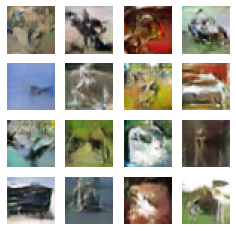

Time for training : 2548 sec


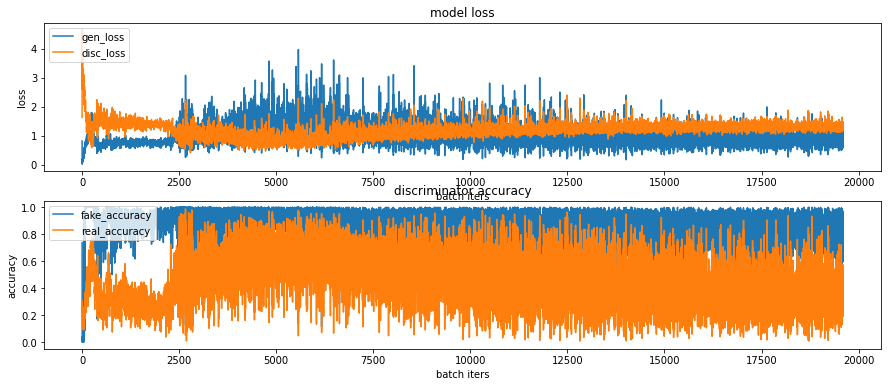

In [222]:
EPOCHS = 100
train(train_dataset, epochs = EPOCHS, save_every = save_every)

- 이미지 퀄리티가 별로 나아진 것 같지 않다.
- gen_loss가 더 높아졌다.
- real_accuracy가 높아졌다.
- gen_loss가 꾸준히 낮아지고 disc_loss가 꾸준히 올라가는 중이라 더 학습 시켜보면 이미지 퀄리티가 좋아질 듯 하다.

### 학습과정 시각화하기

In [156]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1487384 Nov 30 08:09 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


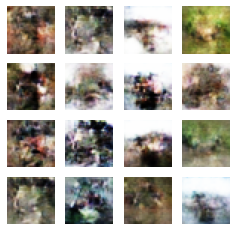

Time for training : 3067 sec


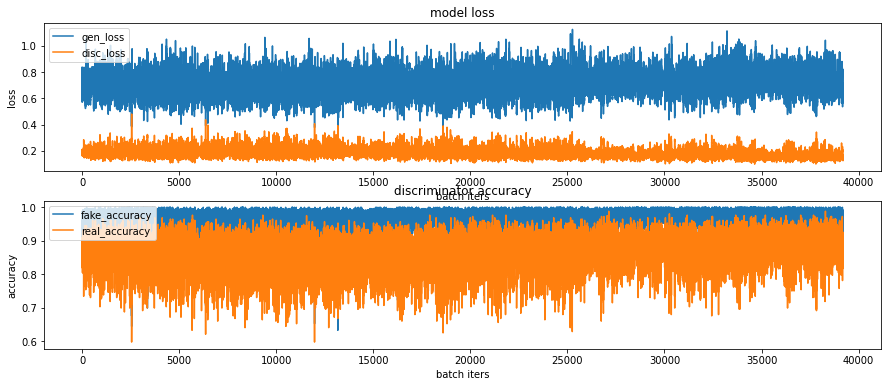

In [157]:
# 한번 더 학습
EPOCHS = 200
train(train_dataset, epochs = EPOCHS, save_every = save_every)

### 회고

#### 잘한 점
- GCGAN을 적용하여 이미지를 생성해 보았다.
#### 문제점
- 이미지가 실제 같지 않고, fake accuracy가 높다.
#### 배운 점
- 이미지 생성이 어렵구나.
- generator와 excriminator의 균형이 중요한 것 같다.